# Apply Low pass filter on drifters
- we have 1 month before and 1 month after matchup 

In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import pyproj

# from rasterio.transform import Affine

import matplotlib.pyplot as plt
import matplotlib.colors as cl

import hvplot.xarray

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.geodesic as cgeo

crs = ccrs.PlateCarree()
import cmocean.cm as cm

# from xgcm import Grid
from xhistogram.xarray import histogram
import warnings

warnings.filterwarnings("ignore")

import os
from glob import glob

#from histlib.cstes import zarr_dir, labels, matchup_dir
#import histlib.matchup as match

/home1/datahome/mdemol/.miniconda3/envs/histenv2/lib/python3.9/site-packages/dask/config.py:742: FutureWarning: Dask configuration key 'distributed.scheduler.transition-log-length' has been deprecated; please use 'distributed.admin.low-level-log-length' instead
  warnings.warn(
/home1/datahome/mdemol/.miniconda3/envs/histenv2/lib/python3.9/site-packages/dask/config.py:742: FutureWarning: Dask configuration key 'distributed.comm.recent-messages-log-length' has been deprecated; please use 'distributed.admin.low-level-log-length' instead
  warnings.warn(


In [2]:
# FOR AURELIEN
zarr_dir = '/home/datawork-lops-osi/aponte/margot/historical_coloc'
l = 'argos_Jason-3_2020'
matchup_dir = '/home/datawork-lops-osi/aponte/margot/historical_coloc_ok/matchup'

In [3]:
if True:
    from dask.distributed import Client
    from dask_jobqueue import PBSCluster

    cluster = PBSCluster(cores=7, processes=7, walltime="04:00:00")
    w = cluster.scale(jobs=1)

client = Client(cluster)
client

Connection method: Cluster object,Cluster type: dask_jobqueue.PBSCluster
Dashboard: http://10.148.0.108:8787/status,
Dashboard: http://10.148.0.108:8787/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.148.0.108:44182,Workers: 0
Dashboard: http://10.148.0.108:8787/status,Total threads: 0
Started: Just now,Total memory: 0 B


# Load colocation

In [4]:
# create 
ds_data = xr.open_zarr(os.path.join(zarr_dir,f'{l}.zarr'))[['__site_matchup_indice','alti_time_mid', 'alti___distance','drifter_vx', 'drifter_vy', 'drifter_acc_x','drifter_coriolis_x', 'drifter_acc_y','drifter_coriolis_y', 'f' ]].isel(obs=slice(0,500)).chunk({'obs':50,'site_obs':-1}).persist()
ds_data = ds_data.where(ds_data.alti___distance<2e5, drop=True).chunk({'obs':500, 'site_obs':-1})
ds_data

<xarray.Dataset>
Dimensions:                (obs: 86, site_obs: 1489, alti_time_mid: 210)
Coordinates:
  * alti_time_mid          (alti_time_mid) float64 0.5 1.5 2.5 ... 208.5 209.5
    alti_x_mid             (obs, alti_time_mid) float64 dask.array<chunksize=(86, 210), meta=np.ndarray>
    alti_y_mid             (obs, alti_time_mid) float64 dask.array<chunksize=(86, 210), meta=np.ndarray>
    drifter_lat            (obs, site_obs) float64 dask.array<chunksize=(86, 1489), meta=np.ndarray>
    drifter_lon            (obs, site_obs) float64 dask.array<chunksize=(86, 1489), meta=np.ndarray>
    drifter_time           (obs, site_obs) datetime64[ns] dask.array<chunksize=(86, 1489), meta=np.ndarray>
    drifter_x              (obs, site_obs) float64 dask.array<chunksize=(86, 1489), meta=np.ndarray>
    drifter_y              (obs, site_obs) float64 dask.array<chunksize=(86, 1489), meta=np.ndarray>
    lat                    (obs) float64 dask.array<chunksize=(86,), meta=np.ndarray>
    lon                    (obs) float64 dask.array<chunksize=(86,), meta=np.ndarray>
  * obs                    (obs) int64 0 1 2 3 4 5 6 7 ... 82 83 84 85 86 87 88
    time                   (obs) datetime64[ns] dask.array<chunksize=(86,), meta=np.ndarray>
Dimensions without coordinates: site_obs
Data variables:
    __site_matchup_indice  (obs) float64 dask.array<chunksize=(86,), meta=np.ndarray>
    alti___distance        (obs) float64 dask.array<chunksize=(86,), meta=np.ndarray>
    drifter_vx             (obs, site_obs) float64 dask.array<chunksize=(86, 1489), meta=np.ndarray>
    drifter_vy             (obs, site_obs) float64 dask.array<chunksize=(86, 1489), meta=np.ndarray>
    drifter_acc_x          (obs, site_obs) float64 dask.array<chunksize=(86, 1489), meta=np.ndarray>
    drifter_coriolis_x     (obs, site_obs) float64 dask.array<chunksize=(86, 1489), meta=np.ndarray>
    drifter_acc_y          (obs, site_obs) float64 dask.array<chunksize=(86, 1489), meta=np.ndarray>
    drifter_coriolis_y     (obs, site_obs) float64 dask.array<chunksize=(86, 1489), meta=np.ndarray>
    f                      (obs) float64 dask.array<chunksize=(86,), meta=np.ndarray>
Attributes:
    __id:                   CMEMS-L3-SLA-Jason-3__argos
    __time_coverage_end:    2020-07-01T00:00:00
    __time_coverage_start:  2020-01-01T00:00:00

# Apply low pass filter

In [5]:
var = ['drifter_x', 'drifter_y','drifter_time','f', 'drifter_vx', 'drifter_vy', 'drifter_acc_x', 'drifter_acc_y', 'drifter_coriolis_x', 'drifter_coriolis_y',]

def add_low_pass_filter_to_data(ds, T=5, cutoff=2) : 
    """ Return dataset with filtered trajectories acceleration and coriolis term 
        T: window length days
        cutoff : cut off frequency in cpd
    """
    from scipy.signal import filtfilt
    from scipy.integrate import cumulative_trapezoid
    from scipy.optimize import minimize
    # coefficients
    dt = (ds.drifter_time.diff('site_obs')/pd.Timedelta('1D')).mean()  # in days
    from pynsitu.tseries import generate_filter

    dss = ds[['drifter_vx', 'drifter_vy',]].compute().fillna(0)
    if not isinstance(cutoff, list) : cutoff=[cutoff]
    for cto in cutoff :
        taps = generate_filter(band="low", dt=dt, T=T, bandwidth=cto)
        print(len(taps))
        try : 
            vx = xr.DataArray(filtfilt(taps, 1, dss.drifter_vx),dims=['obs', 'site_obs'])
            vy = xr.DataArray(filtfilt(taps, 1, dss.drifter_vy), dims=['obs', 'site_obs'])
        except :
            print('padlen modified')
            vx = xr.DataArray(filtfilt(taps, 1, dss.drifter_vx, padlen = len(dss.drifter_vx)),dims=['obs', 'site_obs'])
            vy = xr.DataArray(filtfilt(taps, 1, dss.drifter_vy, padlen = len(dss.drifter_vx)), dims=['obs', 'site_obs'])
            
        cutoffstr = str(cto).replace('.','')

        
        
        ds[f"drifter_acc_x_{cutoffstr}"] = (vx.differentiate("site_obs")/3600).assign_attrs(**ds.drifter_acc_x.attrs).assign_attrs(description= ds.drifter_acc_x.attrs['description'] + f' filtered with {cto} cpd frequency',cutoff=cto)
        ds[f"drifter_acc_y_{cutoffstr}"] = (vy.differentiate("site_obs")/3600).assign_attrs(**ds.drifter_acc_x.attrs).assign_attrs(description= ds.drifter_acc_y.attrs['description'] + f' filtered with {cto} cpd frequency',cutoff=cto)
        ds[f"drifter_coriolis_x_{cutoffstr}"] = (-vy * ds.f).assign_attrs(ds.drifter_coriolis_x.attrs).assign_attrs(description= ds.drifter_coriolis_x.attrs['description'] + f' filtered with {cto} cpd frequency',cutoff=cto)
        ds[f"drifter_coriolis_y_{cutoffstr}"] = (vx * ds.f).assign_attrs(ds.drifter_coriolis_y.attrs).assign_attrs(description= ds.drifter_coriolis_y.attrs['description'] + f' filtered with {cto} cpd frequency',cutoff=cto)

In [6]:
add_low_pass_filter_to_data(ds_data, T=5, cutoff=1)

116


# PB for traj with na values at the beginning/end : How to get the end ?
- pb de nan à la fin des traj ? il pad avec les nan ?
- inverser series temporelles ?

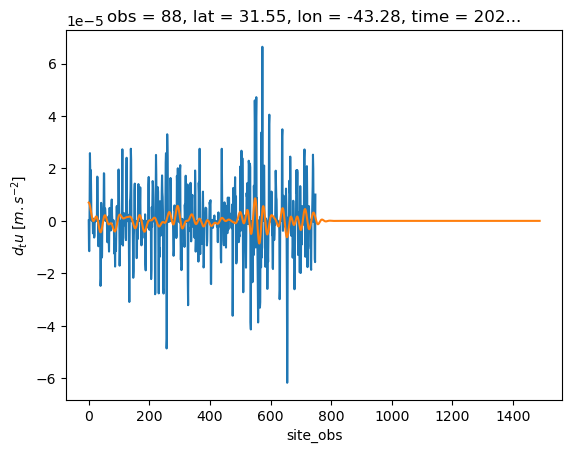

In [7]:
i=-1
ds_ = ds_data.isel(obs=i)
ds_ = ds_.reset_coords(['drifter_x', 'drifter_y'])
ds_.drifter_acc_x.plot()
ds_.drifter_acc_x_1.plot()

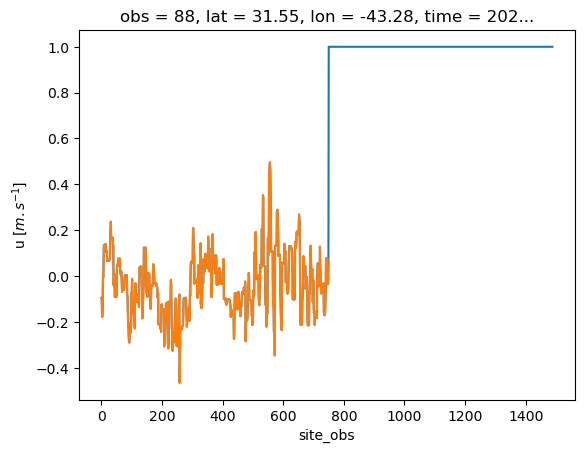

In [8]:
ds1 = ds_data.isel(obs=-1)
ds1.drifter_vx.where(ds1.drifter_vx.notnull(), 1).plot()
ds1.drifter_vx.dropna(dim='site_obs').plot()

### Dropping nan solve PB, but need a for loop on trajectories (dim obs) 

## NO PB

In [15]:
i=0
ds_ = ds_data.isel(obs=i)
ds_ = ds_.reset_coords(['drifter_x', 'drifter_y'])
ds_.drifter_acc_x.hvplot(kind='scatter', label='no filter')*ds_.drifter_acc_x_1.hvplot(kind='scatter', label= 'cutoff=1')

:Overlay
   .Scatter.No_filter       :Scatter   [drifter_time]   (drifter_acc_x)
   .Scatter.Cutoff_equals_1 :Scatter   [drifter_time]   (drifter_acc_x_1)

In [16]:
ds_.drifter_coriolis_x.hvplot(kind='scatter', label='no filter')*ds_.drifter_coriolis_x_1.hvplot(kind='scatter', label= 'cutoff=1')

:Overlay
   .Scatter.No_filter       :Scatter   [drifter_time]   (drifter_coriolis_x)
   .Scatter.Cutoff_equals_1 :Scatter   [drifter_time]   (drifter_coriolis_x_1)

# Add to matchup file

In [9]:
# SELECT MATCHUP
cc = [l for l in list(ds_data.coords)if l not in ['obs', 'box_x', 'box_y', 'alti_time_mid']]
ds_data = ds_data.reset_coords(cc)
idx = ds_data.__site_matchup_indice.astype(int).compute()
dsmf = ds_data.sel(site_obs=idx).isel( alti_time_mid=ds_data.dims['alti_time_mid']//2).drop(["alti_time_mid", "alti_x_mid", "alti_y_mid"])
for v in dsmf.variables:
    dsmf[v].attrs = ds_data[v].attrs

In [10]:
# MATCHUP FILE WITHOUT FILTER
dsm = xr.open_dataset(os.path.join(matchup_dir, f'matchup_{l}.zarr'))

In [11]:
## CHECK MATCHUP SELECTION
(dsm.drifter_acc_x_0 == dsmf.drifter_acc_x).compute()

<xarray.DataArray (obs: 86)>
array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True])
Coordinates:
    alti___distance         (obs) float64 3.982e+04 1.868e+05 ... 1.057e+05
    alti___time_difference  (obs) float64 255.0 456.0 ... 1.557e+03 1.253e+03
    lat                     (obs) float64 -21.25 31.14 -21.18 ... 31.47 31.55
    lon                     (obs) float64 52.31 -42.48 52.17 ... -43.12 -43.28
  * obs                     (obs) int64 0 1 2 3 4 5 6 7 ... 82 83 84 85 86 87 88
    time                    (obs) datetime64[ns] 2020-01-02T02:00:00 ... 2020...

In [12]:
## MERGE MATCHUP + FILTERED MATCHUP

In [13]:
ds = xr.merge([dsm, dsmf.drop(['alti___distance', 'time', 'lat', 'lon','drifter_acc_x','drifter_coriolis_x'])])

In [14]:
ds

<xarray.Dataset>
Dimensions:                                             (obs: 86)
Coordinates:
    alti___distance                                     (obs) float64 ...
    alti___time_difference                              (obs) float64 ...
    lat                                                 (obs) float64 ...
    lon                                                 (obs) float64 ...
  * obs                                                 (obs) int64 0 1 ... 88
    time                                                (obs) datetime64[ns] ...
Data variables: (12/58)
    alti_ggx_adt_filtered                               (obs) float64 ...
    alti_ggx_adt_filtered_ocean_tide                    (obs) float64 ...
    alti_ggx_adt_filtered_ocean_tide_internal_tide      (obs) float64 ...
    alti_ggx_adt_filtered_ocean_tide_internal_tide_dac  (obs) float64 ...
    alti_ggx_adt_unfiltered                             (obs) float64 ...
    alti_ggx_adt_unfiltered_denoised                    (obs) float64 ...
    ...                                                  ...
    drifter_coriolis_y                                  (obs) float64 dask.array<chunksize=(86,), meta=np.ndarray>
    f                                                   (obs) float64 dask.array<chunksize=(86,), meta=np.ndarray>
    drifter_acc_x_1                                     (obs) float64 1.289e-...
    drifter_acc_y_1                                     (obs) float64 3.326e-...
    drifter_coriolis_x_1                                (obs) float64 dask.array<chunksize=(86,), meta=np.ndarray>
    drifter_coriolis_y_1                                (obs) float64 dask.array<chunksize=(86,), meta=np.ndarray>
Attributes:
    __id:                   CMEMS-L3-SLA-Jason-3__argos
    __time_coverage_end:    2020-07-01T00:00:00
    __time_coverage_start:  2020-01-01T00:00:00

# Directly in matchup_one

In [4]:
from histlib.cstes import labels
from histlib.matchup import matchup_dataset_one
l = labels[1]
ds = matchup_dataset_one(l)
ds

233
233
233
233
233


<xarray.Dataset>
Dimensions:                                             (obs: 86)
Coordinates:
  * obs                                                 (obs) int64 0 1 ... 88
    alti___distance                                     (obs) float64 dask.array<chunksize=(86,), meta=np.ndarray>
    alti___time_difference                              (obs) float64 dask.array<chunksize=(86,), meta=np.ndarray>
    lat                                                 (obs) float64 dask.array<chunksize=(86,), meta=np.ndarray>
    lon                                                 (obs) float64 dask.array<chunksize=(86,), meta=np.ndarray>
    time                                                (obs) datetime64[ns] dask.array<chunksize=(86,), meta=np.ndarray>
Data variables: (12/70)
    drifter_typebuoy                                    (obs) object dask.array<chunksize=(86,), meta=np.ndarray>
    alti_ggx_dac                                        (obs) float64 dask.array<chunksize=(86,), meta=np.ndarray>
    alti_ggx_internal_tide                              (obs) float64 dask.array<chunksize=(86,), meta=np.ndarray>
    alti_ggx_mdt                                        (obs) float64 dask.array<chunksize=(86,), meta=np.ndarray>
    alti_ggx_ocean_tide                                 (obs) float64 dask.array<chunksize=(86,), meta=np.ndarray>
    alti_ggx_sla_filtered                               (obs) float64 dask.array<chunksize=(86,), meta=np.ndarray>
    ...                                                  ...
    e5_cstrio_z15_alti_wd_y                             (obs) float64 dask.array<chunksize=(86,), meta=np.ndarray>
    e5_cstrio_z15_drifter_wd_x                          (obs) float64 dask.array<chunksize=(86,), meta=np.ndarray>
    e5_cstrio_z15_drifter_wd_y                          (obs) float64 dask.array<chunksize=(86,), meta=np.ndarray>
    alti_ggx_adt_filtered_ocean_tide                    (obs) float64 dask.array<chunksize=(86,), meta=np.ndarray>
    alti_ggx_adt_filtered_ocean_tide_internal_tide      (obs) float64 dask.array<chunksize=(86,), meta=np.ndarray>
    alti_ggx_adt_filtered_ocean_tide_internal_tide_dac  (obs) float64 dask.array<chunksize=(86,), meta=np.ndarray>
Attributes:
    __id:                   CMEMS-L3-SLA-Jason-3__argos
    __time_coverage_end:    2020-07-01T00:00:00
    __time_coverage_start:  2020-01-01T00:00:00

In [5]:
cluster.close()